In [1]:
include("../src/init.jl")
include("../src/fct.jl")
include("../src/worker_fct.jl")
data_type = "cal"
dataset = "v07.01"

"v07.01"

## sort_data_all_01-new.jl
For several runs

In [ ]:
meta_key_file = "datasets/run0053-run0114-cal-analysis.txt";
meta_keys = CSV.read(meta_key_file);
channels = 0:1:36
event_step = Int(1e4)

current_dir = pwd()
ddir = "/remote/ceph/group/gerda/data/phase2/blind/" * dataset * "/gen/"
cd(ddir)
filenames1 = []
filenames4 = []
for meta_key in meta_keys[1]
    filename1 = ddir * glob("tier1/ged/" * data_type * "/" * split(meta_key, "-")[2] * "/" * meta_key * "*.root")[1]
    filename4 = ddir * glob("tier4/all/" * data_type * "/" * split(meta_key, "-")[2] * "/" * meta_key * "*.root")[1]
    push!(filenames1, filename1)
    push!(filenames4, filename4)
end
cd(current_dir)

if data_type == "phy"
    base_path = "pulses/data/raw_" * dataset * "/"
elseif data_type == "cal"
    base_path = "pulses/calib/raw_" * dataset * "/"
end
log_file = base_path * "log.json"
if !isdir(base_path)
    mkpath(base_path)
end
if !isfile(log_file)
    open(log_file, "w") do f
        JSON.print(f, Dict(), 4)
    end
    global log = Dict()
else
    global log = JSON.parsefile(log_file)
end;

for i in eachindex(filenames4)
    start_t = now()
    run = parse(Int64, split(split(filenames4[i], "gerda-run")[2], "-")[1])
    filename1 = filenames1[i]
    filename4 = filenames4[i]
    
    @info("Run " * string(run) * " | file " * string(i) * " of total " * string(length(filenames4)))
    log = JSON.parsefile(log_file)
    if length(keys(log)) >= 1
        estimation = 0
        for k in keys(log)
            estimation += log[k]
        end
        estimation /= length(keys(log))
        fileinfo = stat(filename4)
        est_t = round(fileinfo.size * estimation / 60, digits=1)
        @info("Estimated time for this file: " * string(est_t) * " min")
        total_filesize = 0
        for f in i:length(filenames4)
            total_filesize += stat(filenames4[f]).size
        end
        est_t = total_filesize * estimation / 60
        unit = " s"
        if est_t/60/60/24 > 1
            est_t /= 60*60*24
            unit = " d"
        elseif est_t/60/60 > 1
            est_t /= 60*60
            unit = " h"
        elseif est_t/60 > 1
            est_t /= 60
            unit = " min"
        end
        @info("Estimated time till completion: " * string(round(est_t, digits=1)) * unit)
    end
    @info("------------------------------")
    

    if true#!(filename4 in keys(JSON.parsefile(log_file)))
        @info("Load Tier4")
        @time tier4 = Table(TFile(filename4)["tier4"]);
        temp_E = sum.(tier4.energy[:])

        index_1 = findall(x->x == 1, tier4.multiplicity[:])
        index_2 = findall(y->y > 300, temp_E[index_1])
        index_3 = findall(x->x == 0, tier4.isBL[index_1[index_2]])
        index_4 = findall(x->x == 0, tier4.isTP[index_1[index_2[index_3]]])
        filtered_index = index_1[index_2[index_3[index_4]]]
        if length(filtered_index) > 0
            @info("Number of events: " * string(length(temp_E)))
            @info("Number of events after filter: " * string(length(filtered_index)))
            steps = []
            s = 1
            while s <= length(filtered_index)
                a = s
                b = s + event_step - 1 <= length(filtered_index) ? s+event_step-1 : length(filtered_index)
#                 println(string(filtered_index[a]) * " - " * string(filtered_index[b]))
                push!(steps, [a,b])
                s += event_step
            end
            return steps
            for s in steps
                result = Table( energy       = [],
                        run          = [],
                        channel      = [],
                        AEvetoed     = [],
                        datasetID    = [],
                        AEclassifier = [],
                        waveform     = [])
                IJulia.clear_output(true)
                run_str = split(basename(filename4), "-")[2]
                @info("Run " * run_str * " | file " * string(i) * " of total " * string(length(filenames4)))
                @info("Step " * string(findfirst(x->x == s, steps)) * " of " * string(length(steps)))
                file = base_path * run_str * "/"
                if !isdir(file)
                    mkpath(file)
                end
                file *= basename(filename4) * lpad(findfirst(x->x == s, steps), 4, "0") * ".h5"
                if !isfile(file)
                    
                    tmp = filtered_index[s[1]:s[2]]
                    @info("Event " * string(tmp[1]) * " until " * string(tmp[end]))
                    tier4 = Table(TFile(filename4)["tier4"])[tmp];
                    @info("Load Tier1")
                    @time treeTier1 = TFile(filename1)["MGTree"].event;
                    @info("Apply first filter to Tier1 & Tier4")
                    @time waveforms = TypedTables.Table(raw2mgtevent.(treeTier1[tmp])).fAuxWaveforms
        #             waveforms = waveforms[tmp]
                    if length(tmp) > 0
                        run_str = split(basename(filename4), "-")[2]
                        run = parse(Int64, split(run_str, "run")[2])

                        pro = Progress(length(channels), dt=0.5,
                            barglyphs=BarGlyphs('|','█', ['▁' ,'▂' ,'▃' ,'▄' ,'▅' ,'▆', '▇'],' ','|',),
                            barlen=10);
                        for ch in channels

                            tmp = findall(y->y[ch + 1] != 0, tier4.energy)
                            if length(tmp) > 0
                                waveform = []
                                for i in tmp
                                    if data_type == "phy"
                                        push!(waveform, waveforms[i][ch + 1].wf)
                                    else
                                        push!(waveform, waveforms[i][1].wf)
                                    end
                                end

                                AEvetoed     = []
                                datasetID    = []
                                AEclassifier = []
                                for i in tmp
                                    push!(AEvetoed,     tier4[i].isAoEvetoed[ch+1])
                                    push!(datasetID,    tier4[i].datasetID[ch+1])
                                    push!(AEclassifier, tier4[i].AoEclassifier[ch+1])
                                end

                                append!(result, Table(  energy       = sum.(tier4.energy[tmp]),
                                                        run          = Int.(zeros(length(tmp)) .+ run),
                                                        channel      = Int.(zeros(length(tmp)) .+ ch),
                                                        AEvetoed     = AEvetoed,
                                                        datasetID    = datasetID,
                                                        AEclassifier = AEclassifier,
                                                        waveform     = StructArray{RDWaveform}(Array{RDWaveform,1}(waveform))))
                            end
                            next!(pro)
                        end
                    end
                    if size(result,1) > 0
                        file = base_path * run_str * "/"
                        file *= basename(filename4) * lpad(findfirst(x->x == s, steps), 4, "0") * ".h5"
                        HDF5.h5open(file, "w") do h5f
                            LegendHDF5IO.writedata( h5f, "data", Table( energy       = float.(result.energy),
                                                                        run          = Int.(result.run),
                                                                        channel      = Int.(result.channel),
                                                                        AEvetoed     = Int.(result.AEvetoed),
                                                                        datasetID    = Int.(result.datasetID),
                                                                        AEclassifier = float.(result.AEclassifier),
                                                                        waveform     = StructArray{RDWaveform}(Array{RDWaveform,1}(result.waveform))))
                        end
                    end
                end
            end
            log = JSON.parsefile(log_file)
            dt = now() - start_t
            fileinfo = stat(filenames4[1])
            fileinfo.size
            log[filename4] = (dt.value / 1000) / fileinfo.size
            open(log_file, "w") do f
                JSON.print(f, log, 4)
            end
        end
    end
    IJulia.clear_output(true)
#     Base.run(`clear`)
    log = JSON.parsefile(log_file)
    @info(string(length(log)) * " of " * string(length(filenames4)) * " done!")
end

# combine log files

In [ ]:
base_path = "../../waveforms/calib/raw_" * dataset * "/"

#
# Load workers log file
log_files = glob(base_path * "log-*.json")
log = Dict()
for file in log_files
    tmp = JSON.parsefile(file)
    for (k,v) in tmp
        log[k] = v
    end
end
for file in log_files
    open(file, "w") do f
        JSON.print(f, log, 4)
    end
end

# Splitting into detectors (Nov 2020)

In [2]:
# function main(args)
#     return args
# end
# Load inline arguments for worker unit
# num_workers, this = main(ARGS)
num_workers = 1#parse(Int64, num_workers)
this = 1#parse(Int64, this)

println("Worker " * string(this) * " of " * string(num_workers))
#
# Load packages and functions
include("../src/init.jl")
include("../src/fct.jl")
include("../src/worker_fct.jl")
data_type = "cal" # phy
dataset = "v07.01"

if data_type == "phy"
    plots_base_path = "../../waveforms/data/plots/raw_" * dataset * "/"
    base_path_raw   = "../../waveforms/data/raw_" * dataset * "/"
    base_path       = "../../waveforms/data/" * dataset * "/"
elseif data_type == "cal"
    plots_base_path = "../../waveforms/calib/plots/raw_" * dataset * "/"
    base_path_raw   = "../../waveforms/calib/raw_" * dataset * "/"
    base_path       = "../../waveforms/calib/" * dataset * "/"
end
number_of_pulses = 1e4
bl_range = 1:1:200


files = glob(base_path_raw * "*/*.h5");
files = get_share_for_worker(files, num_workers, this)

data_cal = Dict()
for ch in [19]#0:1:36
    data_cal[string(ch)] = Dict()
    data_cal[string(ch)]["data"] = Table(energy = [], run = [], channel = [], AoEvetoed = [], datasetID = [], AoEclassifier = [], A = [], E = [], waveform = [])
    data_cal[string(ch)]["counter"] = 1
end

Worker 1 of 1


In [3]:
data_cal

Dict{Any,Any} with 1 entry:
  "19" => Dict{Any,Any}("data"=>Table with 9 columns and 0 rows:…

In [4]:
pro = Progress(length(files), dt=0.5,
                barglyphs=BarGlyphs('|','█', ['▁' ,'▂' ,'▃' ,'▄' ,'▅' ,'▆', '▇'],' ','|',),
                barlen=10);
for file in files
    if stat(file).size > 1000
        data = HDF5.h5open(file, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end;
        for ch in [19]#unique(data.channel)
            ch_str = lpad(ch, 2, "0");
            temp = data |> @filter(_.channel == ch) |> Table
#             cal_factor = cal[string(ch)]["value"]
            waveforms = []
            A = []
            E = []
            for wf in temp.waveform
                pulse   = -1 .*float.(wf.value)
                pulse .-= sum(pulse[bl_range])/length(bl_range)
#                 pulse .*= cal_factor
                push!(A, maximum(multi_mwa(diff(pulse),5,3)))
                push!(E, maximum(multi_mwa(diff(pulse),201,6)))
                push!(waveforms, RDWaveform(wf.time, pulse))
            end
            
            append!(data_cal[string(ch)]["data"], Table(energy   = temp.energy,
                                                        run      = temp.run,
                                                        channel  = temp.channel,
                                                        AoEvetoed= temp.AEvetoed,
                                                        datasetID= temp.datasetID,
                                                        AoEclassifier = temp.AEclassifier,
                                                        A        = A,
                                                        E        = E,
                                                        waveform = waveforms))
            if size(data_cal[string(ch)]["data"],1) >= number_of_pulses
                filename = base_path *  ch_str * "-" * channel_to_name[ch] * "/"
                !isdir(filename) ? mkpath(filename) : "path exists"
                filename *= lpad(data_cal[string(ch)]["counter"], 4, "0") * ".h5"
                data_cal[string(ch)]["counter"] += 1
                HDF5.h5open(filename, "w") do h5f
                    LegendHDF5IO.writedata( h5f, "data", Table( energy       = float.(data_cal[string(ch)]["data"].energy),
                                                                run          = Int.(data_cal[string(ch)]["data"].run),
                                                                channel      = Int.(data_cal[string(ch)]["data"].channel),
                                                                AoEvetoed    = Int.(data_cal[string(ch)]["data"].AoEvetoed),
                                                                datasetID    = Int.(data_cal[string(ch)]["data"].datasetID),
                                                                AoEclassifier= float.(data_cal[string(ch)]["data"].AoEclassifier),
                                                                A            = float.(data_cal[string(ch)]["data"].A),
                                                                E            = float.(data_cal[string(ch)]["data"].E),
                                                                waveform     = StructArray{RDWaveform}(Array{RDWaveform,1}(data_cal[string(ch)]["data"].waveform))))
                end
                data_cal[string(ch)]["data"] = Table(energy = [], run = [], channel = [], AoEvetoed = [], datasetID = [], AoEclassifier = [], A = [], E = [], waveform = [])
            end
        end
    end
    next!(pro)
end
for ch in [19]#0:1:36
    ch_str = lpad(ch, 2, "0");
    if size(data_cal[string(ch)]["data"],1) > 0
        filename = base_path *  ch_str * "-" * channel_to_name[ch] * "/"
        !isdir(filename) ? mkpath(filename) : "path exists"
        filename *= lpad(data_cal[string(ch)]["counter"], 4, "0") * ".h5"
        data_cal[string(ch)]["counter"] += 1
        HDF5.h5open(filename, "w") do h5f
            LegendHDF5IO.writedata( h5f, "data", Table( energy       = float.(data_cal[string(ch)]["data"].energy),
                                                        run          = Int.(data_cal[string(ch)]["data"].run),
                                                        channel      = Int.(data_cal[string(ch)]["data"].channel),
                                                        AoEvetoed     = Int.(data_cal[string(ch)]["data"].AoEvetoed),
                                                        datasetID    = float.(data_cal[string(ch)]["data"].datasetID),
                                                        AoEclassifier= float.(data_cal[string(ch)]["data"].AoEclassifier),
                                                        A            = float.(data_cal[string(ch)]["data"].A),
                                                        E            = float.(data_cal[string(ch)]["data"].E),
                                                        waveform     = StructArray{RDWaveform}(Array{RDWaveform,1}(data_cal[string(ch)]["data"].waveform))))
        end
    end
end

Progress:  65%|██████▄   |  ETA: 1:14:28m19mIOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Progress: 100%|██████████| Time: 3:33:06


# Tl FEP calibration

In [1]:
# function main(args)
#     return args
# end
# Load inline arguments for worker unit
# num_workers, this = main(ARGS)
num_workers = 1#parse(Int64, num_workers)
this = 1#parse(Int64, this)

println("Worker " * string(this) * " of " * string(num_workers))
#
# Load packages and functions
include("../src/init.jl")
include("../src/fct.jl")
include("../src/fitting-fct.jl")
include("../src/worker_fct.jl")
data_type = "cal" # phy
dataset = "v07.01"

plots_base_path = "../../waveforms/calib/plots/" * dataset * "/"
base_path_raw   = "../../waveforms/calib/raw_" * dataset * "/"
base_path       = "../../waveforms/calib/" * dataset * "/"
base_path_fep   = "../../waveforms/calib/" * dataset * "_Tl_FEP/"
cal = JSON.parsefile("../dicts/A_cal.json")
E  = 2614.5;    
ΔE = 1;

function model(par, x)
    scale = try par[1] catch; par[1][1] end
    σ     = try par[2] catch; par[2][1] end
    μ     = try par[3] catch; par[3][1] end
    return @. scale * exp(-0.5 * ((x - μ)^2) / (σ^2)) / (sqrt(2 * π * σ^2))
end

Worker 1 of 1


model (generic function with 1 method)

In [3]:
for ch in [6]#0:1:36
# ch = 19
    files = glob(base_path * lpad(ch, 2, "0") * "-" * channel_to_name[ch] * "/*.h5");
    files = get_share_for_worker(files, num_workers, this);
    result = Table(energy = [], run = [], channel = [], AoEvetoed = [], datasetID = [], AoEclassifier = [], A = [], E = [], waveform = [])
    cal[channel_to_name[ch]] = Dict()

    @showprogress 1 "Collecting Tl events for detector $ch ..." for file in files
        data = HDF5.h5open(file, "r") do h5f
            LegendHDF5IO.readdata(h5f, "data")
        end;
        append!(result, data |> @filter(E - ΔE < _.energy < E + ΔE) |> Table)
    end

    for run in unique(result.run)
            data = result |> @filter(_.run == run &&  maximum(_.waveform.value) > 100) |> Table #Int(_.datasetID) == 0 &&
        if size(data,1) > 100
            A_max = []
            map(x-> push!(A_max, get_avg_maximum(x.waveform.value, 5)/x.energy), data);
            A_max = A_max[findall(x->x > mean(A_max) - 3 * std(A_max), A_max)]
            hist = fit(Histogram, A_max, minimum(A_max):0.00025:maximum(A_max))

            likelihood = let h = hist, f = model
                # Histogram counts for each bin as an array:
                observed_counts = h.weights

                # Histogram binning:
                bin_edges = h.edges[1]
                bin_edges_left = bin_edges[1:end-1]
                bin_edges_right = bin_edges[2:end]
                bin_widths = bin_edges_right - bin_edges_left
                bin_centers = (bin_edges_right + bin_edges_left) / 2

                params -> begin
                    # Log-likelihood for a single bin:
                    function bin_log_likelihood(i)
                        # Simple mid-point rule integration of fit function `f` over bin:
                        expected_counts = bin_widths[i] * f(params, bin_centers[i])
                        logpdf(Poisson(expected_counts), observed_counts[i])
                    end

                    # Sum log-likelihood over bins:
                    idxs = eachindex(observed_counts)
                    ll_value = bin_log_likelihood(idxs[1])
                    for i in idxs[2:end]
                        ll_value += bin_log_likelihood(i)
                    end

                    # Wrap `ll_value` in `LogDVal` so BAT knows it's a log density-value.
                    return LogDVal(ll_value)
                end
            end
            Amax = maximum(A_max)
            Amin = minimum(A_max)
            prior = NamedTupleDist(
                scale = sum(hist.weights)*0.75..sum(hist.weights)*1.25,
                σ = 0.001..0.01,
                µ = Amin..Amax
            )
            parshapes = varshape(prior)
            posterior = PosteriorDensity(likelihood, prior);
            samples = bat_sample(posterior, 10^5, MCMCSampling(sampler = MetropolisHastings(), nchains = 4)).result

            y_fit = model(mode(samples)[1], midpoints(hist.edges[1]))
            y_fit ./= sum(y_fit)
            y_fit .*= sum(hist.weights)
            p = plot(hist, st=:step, label="run" * lpad(run, 4, "0"))
            p = plot!(midpoints(hist.edges[1]), y_fit, label="Fit")
            p = vline!([mode(samples)[1].µ], label="Mean")
            p = plot!(size=(800,600), xlabel="Pulse amplitude / energy [ADC/keV]", ylabel="Samples")
            filename = plots_base_path * "Tl_FEP/" * lpad(ch, 2, "0") * "-" * channel_to_name[ch] * "/run" * lpad(run, 4, "0") * "-pulse_amplitude_over_E.png"
            !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
            savefig(p, filename)
            IJulia.clear_output(true)
            display(p)
            cal[channel_to_name[ch]]["run" * lpad(run, 4, "0")] = [mode(samples)[1].µ, std(samples)[1].µ]
        else
            @info("Not enough data for run" * lpad(run, 4, "0"))
        end
        open("../dicts/A_cal.json", "w") do f
            JSON.print(f, cal, 4)
        end
    end
end

LoadError: [91mMethodError: no method matching MCMCSampling(; sampler=MetropolisHastings{BAT.MvTDistProposal,RepetitionWeighting{Int64},AdaptiveMHTuning}[39m
[91m  proposal: BAT.MvTDistProposal[39m
[91m  weighting: RepetitionWeighting{Int64} RepetitionWeighting{Int64}()[39m
[91m  tuning: AdaptiveMHTuning[39m
[91m, nchains=4)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  MCMCSampling(; mcalg, trafo, nchains, nsteps, init, burnin, convergence, strict, store_burnin, nonzero_weights, callback) at /user/.julia/packages/Parameters/cGriM/src/Parameters.jl:520[91m got unsupported keyword argument "sampler"[39m[39m
[91m[0m  MCMCSampling([91m::AL[39m, [91m::TR[39m, [91m::Any[39m, [91m::Any[39m, [91m::IN[39m, [91m::BI[39m, [91m::CT[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::CB[39m) where {AL<:MCMCAlgorithm, TR<:AbstractDensityTransformTarget, IN<:MCMCInitAlgorithm, BI<:MCMCBurninAlgorithm, CT<:MCMCConvergenceTest, CB<:Function} at /user/.julia/packages/Parameters/cGriM/src/Parameters.jl:501[91m got unsupported keyword arguments "sampler", "nchains"[39m[39m
[91m[0m  MCMCSampling([91m::MCMCSampling[39m; kws...) at /user/.julia/packages/Parameters/cGriM/src/Parameters.jl:530[39m
[91m[0m  ...[39m

In [4]:
ch = 6
files = glob(base_path * lpad(ch, 2, "0") * "-" * channel_to_name[ch] * "/*.h5");
files = get_share_for_worker(files, num_workers, this);
result = Table(energy = [], run = [], channel = [], AoEvetoed = [], datasetID = [], AoEclassifier = [], A = [], E = [], waveform = [])
cal[channel_to_name[ch]] = Dict()

pro = Progress(length(files), dt=0.5,
                barglyphs=BarGlyphs('|','█', ['▁' ,'▂' ,'▃' ,'▄' ,'▅' ,'▆', '▇'],' ','|',),
                barlen=10);
for file in files
    data = HDF5.h5open(file, "r") do h5f
        LegendHDF5IO.readdata(h5f, "data")
    end;
    append!(result, data |> @filter(E - ΔE < _.energy < E + ΔE) |> Table)
    next!(pro)
end

Progress: 100%|██████████| Time: 0:00:40


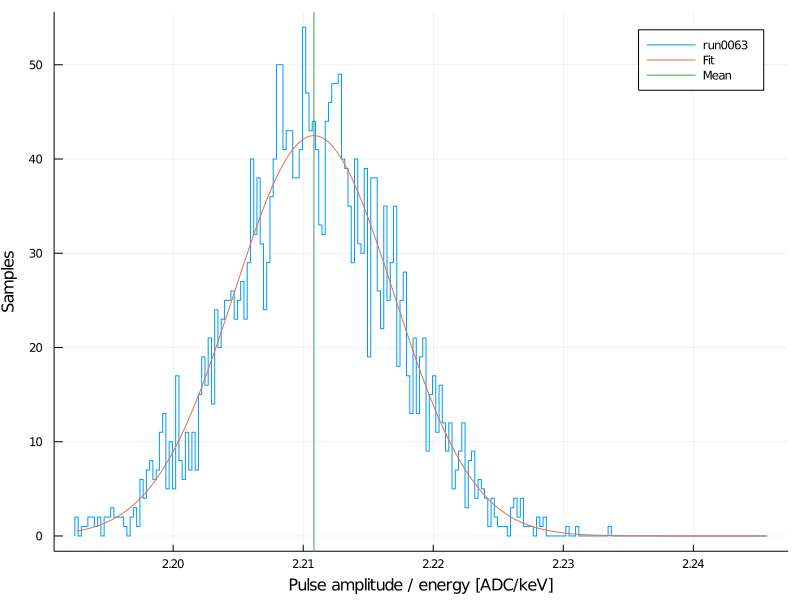

In [20]:
for run in unique(result.run)
#     run = unique(result.run)[i]
    data = result |> @filter(_.run == run&& maximum(_.waveform.value) > 100) |> Table# && Int(_.datasetID) == 0 
    if size(data,1) > 100
        A_max = []
        map(x-> push!(A_max, get_avg_maximum(x.waveform.value, 5)/x.energy), data);
        A_max = A_max[findall(x->x > mean(A_max) - 3 * std(A_max), A_max)]
        hist = fit(Histogram, A_max, minimum(A_max):0.00025:maximum(A_max))

        Amax = maximum(A_max)
        Amin = minimum(A_max)
        
        prior = NamedTupleDist(
            scale = sum(hist.weights)*0.75..sum(hist.weights)*1.25,
            σ = 0.001..0.01,
            µ = Amin..Amax
        )
        display(plot(hist, st=:step))
        
        samples = bat_fit(hist, model, prior; nsamples=5*10^4, nchains=4, params_first=true, norm_expected=false)

        y_fit = model(mode(samples)[1], midpoints(hist.edges[1]))
        y_fit ./= sum(y_fit)
        y_fit .*= sum(hist.weights)
        p = plot(hist, st=:step, label="run" * lpad(run, 4, "0"))
        p = plot!(midpoints(hist.edges[1]), y_fit, label="Fit")
        p = vline!([mode(samples)[1].µ], label="Mean")
        p = plot!(size=(800,600), xlabel="Pulse amplitude / energy [ADC/keV]", ylabel="Samples")
        filename = plots_base_path * "Tl_FEP/" * lpad(ch, 2, "0") * "-" * channel_to_name[ch] * "/run" * lpad(run, 4, "0") * "-pulse_amplitude_over_E.png"
        !isdir(dirname(filename)) ? mkpath(dirname(filename)) : ""
        savefig(p, filename)
        IJulia.clear_output(true)
        display(p)
        cal[channel_to_name[ch]]["run" * lpad(run, 4, "0")] = [mode(samples)[1].µ, std(samples)[1].µ]
    else
        @info("Not enough data for run" * lpad(run, 4, "0"))
    end
    open("../dicts/A_cal.json", "w") do f
        JSON.print(f, cal, 4)
    end
end
# i += 1